# Блочная нормализация
Одним из путей упрощения обучения в глубоких сетях является использование более сложных процедур оптимизации, таких как SGD + момент, RMSProp или Adam. Другая стратегия - изменить архитектуру сети, чтобы упростить ее обучение.Одной из идей в этой области является блочная нормализация, которая была предложена в [3] в 2015 году.

Идея относительно проста. Методы машинного обучения имеют тенденцию работать лучше, когда их входные данные состоят из некоррелированных признаков с нулевым средним и единичной дисперсией. При обучении нейронной сети мы можем предварительно обработать данные, прежде чем загружать их в сеть, чтобы явно декореллировать признаки; это гарантирует, что на первый уровень сети поступают данные, которые характеризуются хорошим распределением. Однако, даже если мы предварительно обрабатываем входные данные, активации на более глубоких слоях сети, скорее всего, больше не будут декореллированы и не будут иметь нулевое среднее или единичную дисперсию. Еще хуже то, что во время обучения распределение призанков на каждом уровне сети будет меняться по мере обновления весов каждого уровня.

Авторы [3] предполагают, что смещение распределения прзнаков внутри глубоких нейронных сетей затрудняет обучение. Чтобы преодолеть это, [3] предлагается вставить в сеть слои блочной нормализации. Во время обучения слой блочной нормализации использует мини-блок данных для оценки среднего и стандартного отклонения каждого признака. Эти средние затем используются для центрирования и нормализации признаков на  мини-блоке. Текущее среднее и текущее стандартное отклонение сохраняются во время обучения, а во время тестирования эти текущие средние  используются для центрирования и нормализации признаков.

Возможно, что эта стратегия нормализации снижает репрезентативную емкость сети, так как иногда для некоторых слоев оптимальными будут признаки, которые не обладают нулевым средним и единичной дисперсией. С этой целью слой блочной нормализации включает в себя обучаемые параметры смещения и масштаба для каждого признака.

[3] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

In [1]:
# As usual, a bit of setup
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

run the following from the cs231n directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


## Блочная нормализация: прямое распространение
В файле `cs231n / layers.py` реализуйте функцию блочной нормализации  `batchnorm_forward` для прямого пути (возможно Вам повезло и функция уже написана). Затем выполните код ниже, чтобы проверить реализацию.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [2.22044605e-17 8.16013923e-17 4.57966998e-17]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [4]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



## Блочная нормализация: обратное рапрстранение
Теперь реализуем обратное распространение для  блочной нормализации в функции `batchnorm_backward`.

Чтобы реализовать обратный путь, вы должны представить граф вычислений для блочной нормализации  и обратное распространение через каждый из промежуточных узлов. Некоторые промежуточные узлы могут иметь несколько исходящих ветвей; обязательно суммируйте градиенты по этим ветвям на  обратном пути.

После реализации функции (возможно Вам повезло и функция уже написана), запустите код ниже, чтобы проверить реализацию обратного распространения.

In [5]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.7029229933676353e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


## Блочная нормализация: альтернативный обратный путь
На лекциях мы говорили о двух разных реализациях обратного пути через сигмовидную нелинейность. Одна из стратегий заключается в том, чтобы представить граф вычислений, состоящий из простых операций через все промежуточные значения. Другая стратегия заключается в выводе производных аналитически на бумаге. Например, вы можете получить очень простую формулу для обратного распространения градиентов через сигмовидную функцию.

Удивительно, но оказывается, что вы можете сделать аналогичное упрощение и для обратного пути в случае блочной нормализации. При заданном множестве входов $X=\begin{bmatrix}x_1\\x_2\\...\\x_N\end{bmatrix}$, 
мы сначала вычисляем среднее $\mu=\frac{1}{N}\sum_{k=1}^N x_k$ и дисперсию $v=\frac{1}{N}\sum_{k=1}^N (x_k-\mu)^2.$    
При вычисленных $\mu$ and $v$ , мы можем вычислить стандартное отклонение $\sigma=\sqrt{v+\epsilon}$  и нормализовать данные $Y$ с помощью $y_i=\frac{x_i-\mu}{\sigma}.$


Решить нашу проблему - это получить $\frac{\partial L}{\partial X}$ из восходящего градиента $\frac{\partial L}{\partial Y}.$ Возможно, было бы сложно прямо рассуждать о градиентах над $X$ и $Y$ - попробуйте рассуждать об этом в терминах $x_i$ и $y_i$ сначала.

Вам нужно будет придумать вывод для $\frac{\partial L}{\partial x_i}$, полагаясь на цепочное правило, чтобы сначала вычислить промежуточные градиенты $\frac{\partial \mu}{\partial x_i}, \frac{\partial v}{\partial x_i}, \frac{\partial \sigma}{\partial x_i},$ затем собрать эти куски для вычисления  $\frac{\partial y_i}{\partial x_i}$. Вы должны убедиться, что каждый из промежуточных шагов максимально прост.

После этого выполните упрощенную прокрутку блочной нормализации с помощью функции `batchnorm_backward_alt` и сравните две реализации, выполнив код ниже (возможно Вам повезло и функция уже написана). Ваши две реализации должны вычислять почти одинаковые результаты, но альтернативная реализация должна быть немного быстрее.

In [6]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_param)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  6.179603584588351e-13
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.00x


## Полносвязанные сети с блочной нормализацией

Теперь, когда у вас есть рабочая реализация блочной нормализации, вернитесь к  классу FullyConnectedNet в файле cs231n / классификаторы / fc_net.py. Измените его реализацию,  добавив блочную нормализацию.

Когда флаг `normalization` принимает значение "batchnorm" в конструкторе, то необходимо  вставить слой блочной нормализации перед каждой нелинейностью ReLU. Выходы последнего слоя сети не нормализуются. После того, как изменения будут сделаны (возможно Вам повезло и код уже дописан), запустите код ниже для проверки градиента.

СОВЕТ. Возможно, вам будет полезно определить дополнительный вспомогательный слой, аналогичный тому, который содержится в файле `cs231n/layer_utils.py`. Если вы решите это сделать, то сделайте это в файле `cs231n/classifiers/fc_net.py`.

In [7]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 3.92e-10
b1 relative error: 2.22e-08
b2 relative error: 2.00e-07
b3 relative error: 4.78e-11
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 7.57e-09
gamma2 relative error: 1.96e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 1.11e-08
b2 relative error: 2.36e-08
b3 relative error: 2.23e-10
beta1 relative error: 6.65e-09
beta2 relative error: 5.69e-09
gamma1 relative error: 8.80e-09
gamma2 relative error: 4.14e-09


##  Блочная нормалиазция для глубоких сетей
Выполните код ниже, чтобы обучить шестислойную сеть на подмножестве из 1000 примеров обучения как с блочной нормализацией, так и без нее.

In [8]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 200) loss: 2.340974
(Epoch 0 / 10) train acc: 0.107000; val_acc: 0.115000
(Epoch 1 / 10) train acc: 0.313000; val_acc: 0.266000
(Iteration 21 / 200) loss: 2.039365
(Epoch 2 / 10) train acc: 0.390000; val_acc: 0.279000
(Iteration 41 / 200) loss: 2.036710
(Epoch 3 / 10) train acc: 0.498000; val_acc: 0.317000
(Iteration 61 / 200) loss: 1.769763
(Epoch 4 / 10) train acc: 0.534000; val_acc: 0.309000
(Iteration 81 / 200) loss: 1.268883
(Epoch 5 / 10) train acc: 0.599000; val_acc: 0.325000
(Iteration 101 / 200) loss: 1.263426
(Epoch 6 / 10) train acc: 0.633000; val_acc: 0.323000
(Iteration 121 / 200) loss: 1.100136
(Epoch 7 / 10) train acc: 0.689000; val_acc: 0.329000
(Iteration 141 / 200) loss: 1.196170
(Epoch 8 / 10) train acc: 0.708000; val_acc: 0.308000
(Iteration 161 / 200) loss: 0.713313
(Epoch 9 / 10) train acc: 0.782000; val_acc: 0.330000
(Iteration 181 / 200) loss: 0.817701
(Epoch 10 / 10) train acc: 0.792000; val_acc: 0.320000
(Iteration 1 / 200) loss: 2.302332
(Epoch

Выполните код, чтобы визуализировать результаты для двух вышеперечисленных сетей. Вы должны обнаружить, что использование блочной нормализации помогает сети сходиться намного быстрее.

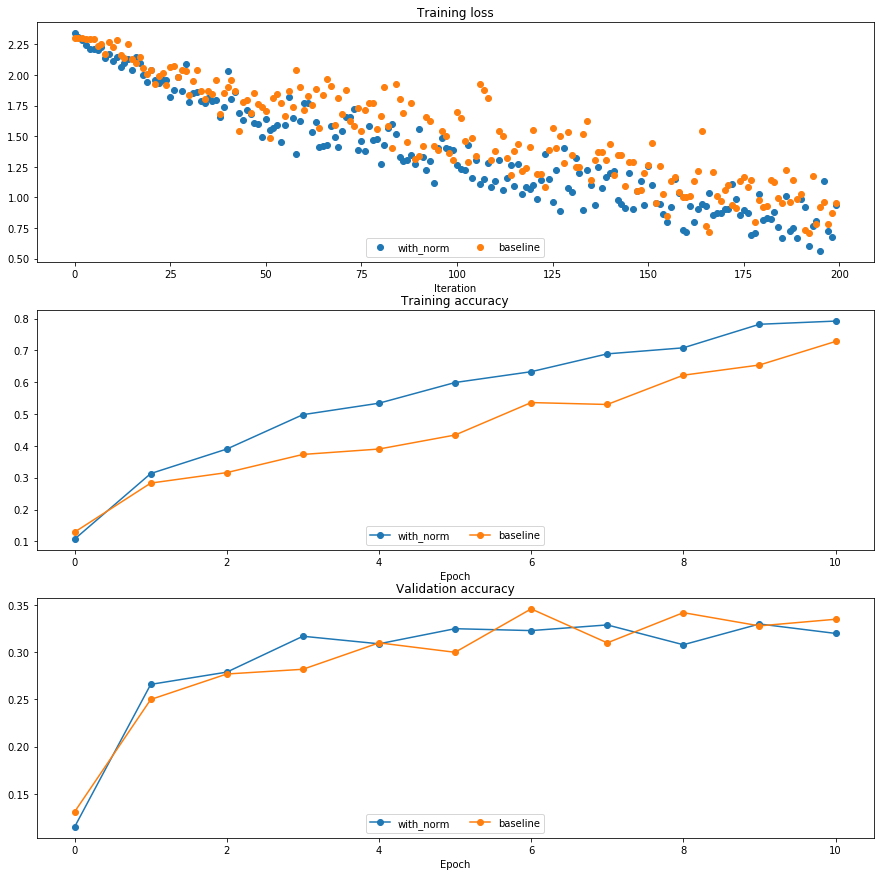

In [9]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Блочная нормализация и инициализация

Проведем небольшой эксперимент для изучения взаимодействия блочной нормализации и инициализации весов.

Первая ячейка будет обучать 8-слойные сети как с бочной нормализацией, так и без нее, используя разные масштабы для инициализации весов. Вторая - будет отображать точность обучения, точность валидации и потери обучения в зависимости от масштаба инициализации весов.

In [11]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale %d / %d/ %f' % (i + 1, len(weight_scales), weight_scale))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batchnorm')
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers_ws[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers_ws[weight_scale] = solver

Running weight scale 1 / 20/ 0.000100
Running weight scale 2 / 20/ 0.000162
Running weight scale 3 / 20/ 0.000264
Running weight scale 4 / 20/ 0.000428
Running weight scale 5 / 20/ 0.000695
Running weight scale 6 / 20/ 0.001129
Running weight scale 7 / 20/ 0.001833
Running weight scale 8 / 20/ 0.002976
Running weight scale 9 / 20/ 0.004833
Running weight scale 10 / 20/ 0.007848
Running weight scale 11 / 20/ 0.012743
Running weight scale 12 / 20/ 0.020691
Running weight scale 13 / 20/ 0.033598
Running weight scale 14 / 20/ 0.054556
Running weight scale 15 / 20/ 0.088587
Running weight scale 16 / 20/ 0.143845
Running weight scale 17 / 20/ 0.233572
Running weight scale 18 / 20/ 0.379269
Running weight scale 19 / 20/ 0.615848
Running weight scale 20 / 20/ 1.000000


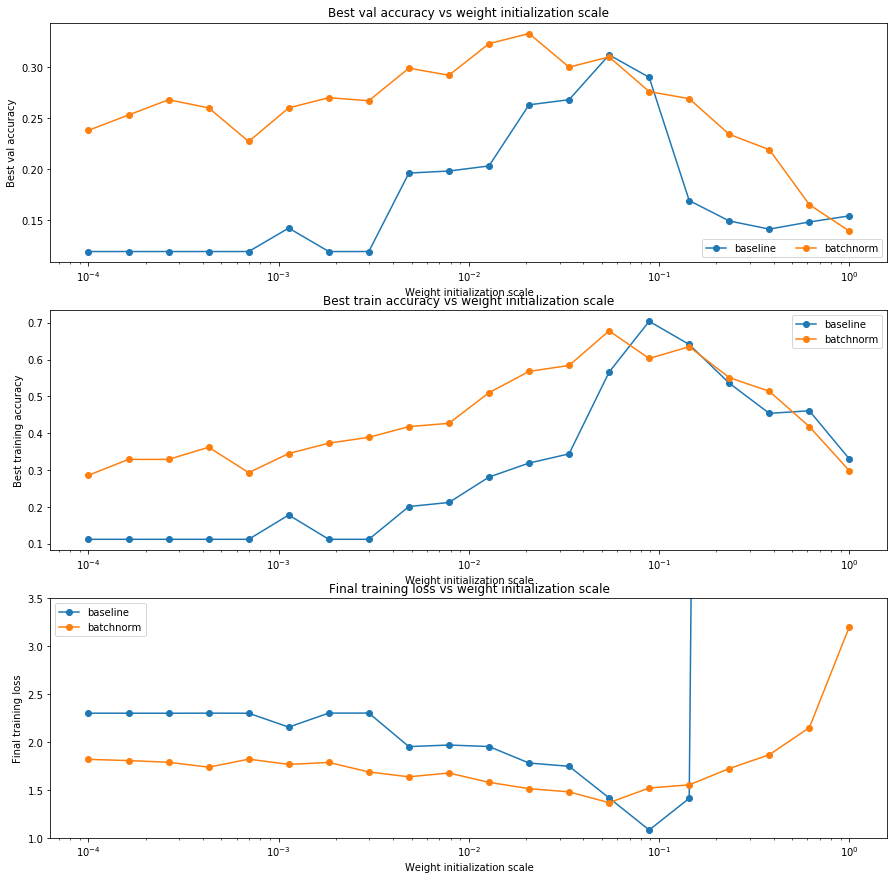

In [14]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers_ws[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))
  
  best_val_accs.append(max(solvers_ws[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

## Вопрос 1:
Describe the results of this experiment. How does the scale of weight initialization affect models with/without batch normalization differently, and why?
Опишите результаты этого эксперимента. Как масштаб инициализации веса влияет на модели с / без блочной нормализации и почему?

## Ответ:


## Блочная нормализация и размер блока
Проведем небольшой эксперимент для изучения взаимосвязи блочной нормализации и размера блока.

Первая ячейка будет обучать 6-слойные сети как с блочной нормализацией, так и без нее с использованием разных размеров блоков. Вторая -  будет отображать точность обучения и точность валидации  с течением времени.

In [15]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


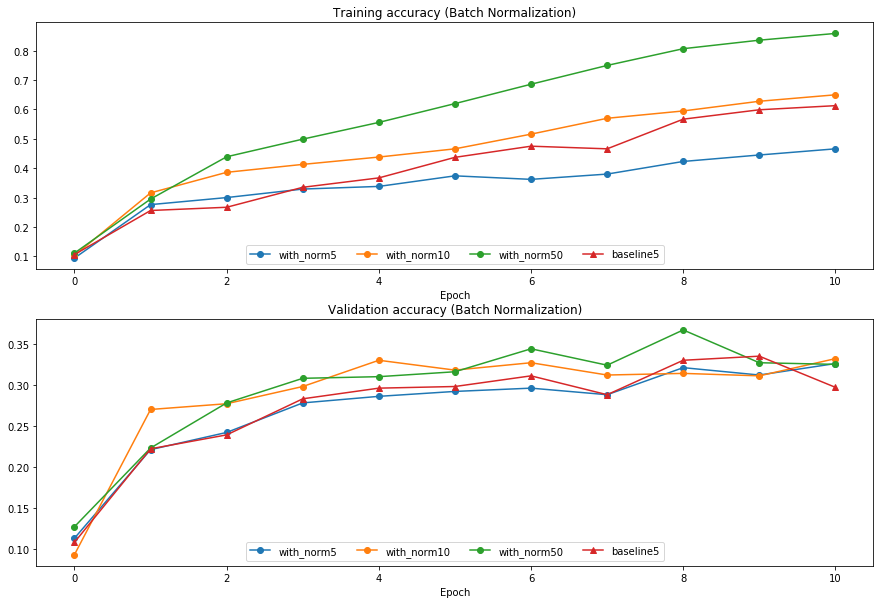

In [16]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Вопрос  2:
Опишите результаты этого эксперимента. Как влияет размер блока на точность обучения/валидации? Почему это происходит?

## Ответ:


# Нормализация на слое

Блочной нормализация  упрощает  обучение сетей, но зависимость от размера блока делает ее менее полезной в сложных сетях, которые имеют ограничение на размер входного блока  (например, из-за ограничений аппаратного обеспечения).

Для смягчения этой проблемы было предложено несколько альтернатив блочной нормализации; одним из таких методов является нормализация на слое [4]. Вместо нормализации блока мы выполняем нормализацию по признакам. Другими словами, при использовании Layer Normalization каждый вектор признаков, соответствующий одной точке данных, нормируется на основе суммы всех членов внутри этого вектора.

[4] [Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer Normalization." stat 1050 (2016): 21.](https://arxiv.org/pdf/1607.06450.pdf)

## Вопрос 3:
Какой из  этапов предварительной обработки данных аналогичен нормализации блока, а какой - нормализации на слое?

1. Масштабирование каждого изображения множества данных таким образом, что каналы RGB для каждоц строки пикселей в изображении в сумме дают 1.
2. Масштабирование каждого изображения множества данных таким образом, что каналы RGB для всех пикселей в изображении в сумме дают 1.
3. Вычитание среднего изображения набора данных из каждого изображения в наборе данных.
4. Установка всех значений RGB в 0 или 1 в зависимости от заданного порогового значения.

## Ответ:


# Нормализация на слое: реализация

Теперь реализуете нормализацию на слое. Этот шаг должен быть относительно прост, так как концептуально реализация почти идентична реализации блочной нормализации. Одно из существенных различий заключается в том, что для нормализации на слое мы не отслеживаем скользящие моменты, и фаза тестирования идентична фазе обучения, где среднее и дисперсия вычисляются непосредственно для каждой точки данных.

Вот что вам нужно сделать:

    В `cs231n/layers.py` реализуете прямой путь для нормализации на слое  в функции `layernorm_forward`.

Запустите ячейку ниже, чтобы проверить свои результаты.

    В `cs231n/layers.py` реализуйте обратный путь для нормализации на слое функции `layernorm_backward`.

Запустите вторую ячейку ниже, чтобы проверить свои результаты.

    Измените `cs231n/classifiers/fc_net.py`, чтобы добавить нормализацию на слое в `FullyConnectedNet`. Когда флаг `normalization` установлен в `"layernorm"` в конструкторе, вы должны вставить код нормализации на слое перед каждой нелинейностью ReLU.

Запустите третью ячейку ниже, чтобы выполнить эксперимент с размером блока при нормализации на слое.

In [17]:
# Check the training-time forward pass by checking means and variances
# of features both before and after layer normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
# Means should be close to zero and stds close to one
print('After layer normalization (gamma=1, beta=0)')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
# Now means should be close to beta and stds close to gamma
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

After layer normalization (gamma=1, beta=0)
  means:  [-4.81096644e-16  0.00000000e+00  7.40148683e-17 -5.55111512e-16]
  stds:   [0.99999995 0.99999999 1.         0.99999969]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [2.99999985 2.99999998 2.99999999 2.99999907]



In [18]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

#You should expect to see relative errors between 1e-12 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0
dgamma error:  4.519489546032799e-12
dbeta error:  2.276445013433725e-12


# Нормализация на слое и размер блока

Теперь мы проведем эксперимент с размером блока и нормализацией на слое вместо нормализации на блоке. По сравнению с предыдущим экспериментом вы должны увидеть заметно меньшее влияние размера блока на историю обучения!

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


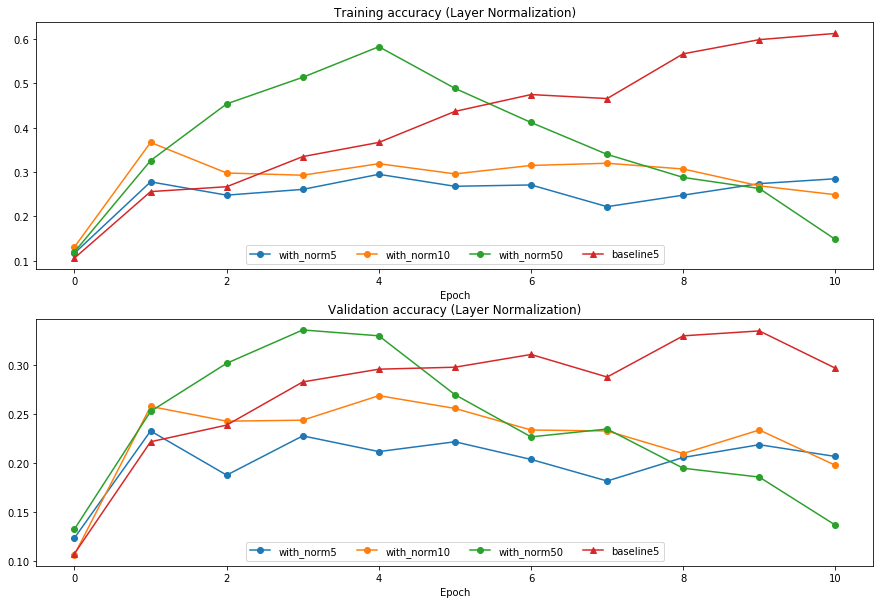

In [19]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layernorm')

plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

## Вопрос 4:
Когда нормализация на слое, вероятно, не будет работать хорошо и почему?

1. При использовании в очень глубокой сети
2. При наличии очень небольшого числа признаков
3. При высоком уровне регуляризации


## Ответ:

